In [1]:
# import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
import tables
import mplfinance as mpf
import my_afml_fncs as my_afml
# from AFML_Ch2_barchart import volume_bars_df
from my_afml_fncs import dropLabels, movingAverageCrossover
from research import drop_label
import seaborn as sns
from matplotlib.patches import Rectangle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


Num of CPU core:  128
Machine info:  Linux-6.8.0-55-generic-x86_64-with-glibc2.39
Python 3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:56:27) [GCC 11.2.0]
Numpy 1.26.4
Pandas 2.2.3


In [2]:
filename_end="2019_2024"
# volume_bars_df = pd.read_hdf("tick_data/bars/volume_bars_50000.h5", key="volume_bars")
# volume_bars_df.head()
# volume_bars_df.shape
volume_bars_df=pd.read_csv(f'tick_data/bars/volume_bars_barchart_{filename_end}.csv')
volume_bars_df['bar_number'] = range(len(volume_bars_df))
dollar_bars_df=pd.read_csv(f'tick_data/bars/dollar_bars_barchart_{filename_end}.csv')
dollar_bars_df['bar_number'] = range(len(dollar_bars_df))

In [3]:
volume_bars_df['Date']=pd.to_datetime(volume_bars_df['Date'])
volume_bars_df.set_index('Date',inplace=True)
dollar_bars_df['Date']=pd.to_datetime(dollar_bars_df['Date'])
dollar_bars_df.set_index('Date',inplace=True)

dollar_bars_df.sort_index(inplace=True)
volume_bars_df.sort_index(inplace=True)


In [4]:
# get daily volatilities
vol=my_afml.getDailyVol(volume_bars_df.Close)
# vol.mean()
# vol.shape
dollar_vol=my_afml.getDailyVol(dollar_bars_df.Close)

In [5]:
# 3.1(a) apply CUSUM filet usings daily vols
es_cusum_events=my_afml.getTEvents(volume_bars_df.Close,vol.mean())
print('Volume bar CUSUM events:',es_cusum_events.shape)
dollar_es_cusum_events=my_afml.getTEvents(dollar_bars_df.Close,dollar_vol.mean())
print('Dollar bar CUSUM events:',dollar_es_cusum_events.shape)

Volume bar CUSUM events: (7187,)
Dollar bar CUSUM events: (48245,)


In [6]:
# 3.1(b) get the t1 vertical barriers, with 1-day
t1=my_afml.getVb(volume_bars_df.Close,es_cusum_events)
dollar_t1=my_afml.getVb(dollar_bars_df.Close,dollar_es_cusum_events)

In [7]:
# volume_bars_df.info()
# dollar_bars_df.info()

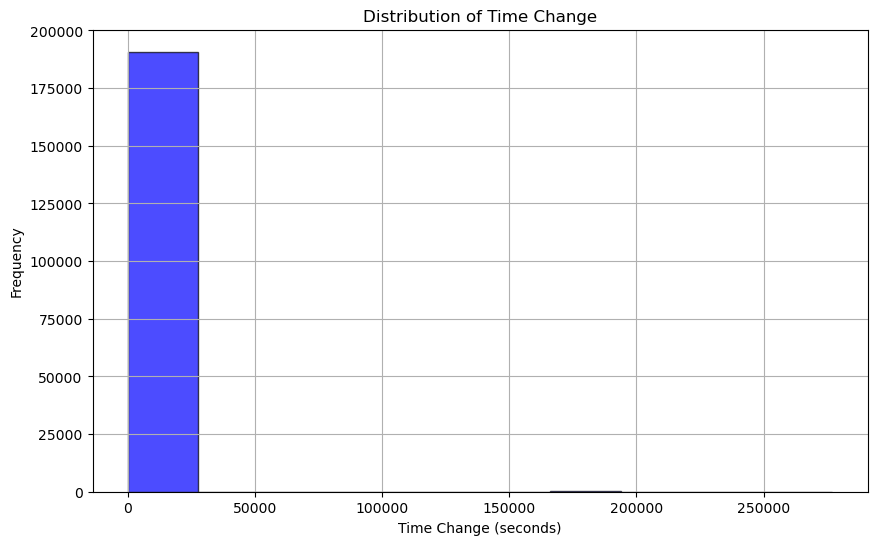

In [8]:
# Calculate change in bar number and time
volume_bars_df['bar_number_change'] = volume_bars_df['bar_number'].diff()
volume_bars_df['time_change'] = volume_bars_df.index.to_series().diff().dt.total_seconds()

# Plot histogram of time changes
plt.figure(figsize=(10, 6))
plt.hist(volume_bars_df['time_change'].dropna(), bins=10, color='blue', alpha=0.7, edgecolor='black')
plt.title('Distribution of Time Change')
plt.xlabel('Time Change (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [9]:
# 3.1(c) apply triple barrier method on the data with ptsl [1,1] and t1 as above, i assume target is daily vol
# this is unrelated to 3.3, trgt, trigger and bins
ptsl=[1,1]
trgt=vol.mean()*volume_bars_df.Close
minRet=0.00003
numThread=12
trigger=my_afml.getEvents(volume_bars_df.Close,es_cusum_events,ptsl,trgt,minRet,numThread,t1)
dollar_trigger=my_afml.getEvents(dollar_bars_df.Close,dollar_es_cusum_events,ptsl,trgt,minRet,numThread,dollar_t1)
# print(trigger,dollar_trigger)
print(trigger.shape,dollar_trigger.shape)



Running processJobs
Running processJobs


2025-03-04 09:53:21.677232 100.0% applyPtSlOnT1 done after 0.01 minutes. Remaining 0.0 minutes..


(7187, 2) (48245, 2)


2025-03-04 09:53:25.438723 100.0% applyPtSlOnT1 done after 0.06 minutes. Remaining 0.0 minutes.


/home/mmx/anaconda3/envs/AFML/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mmx/anaconda3/envs/AFML/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


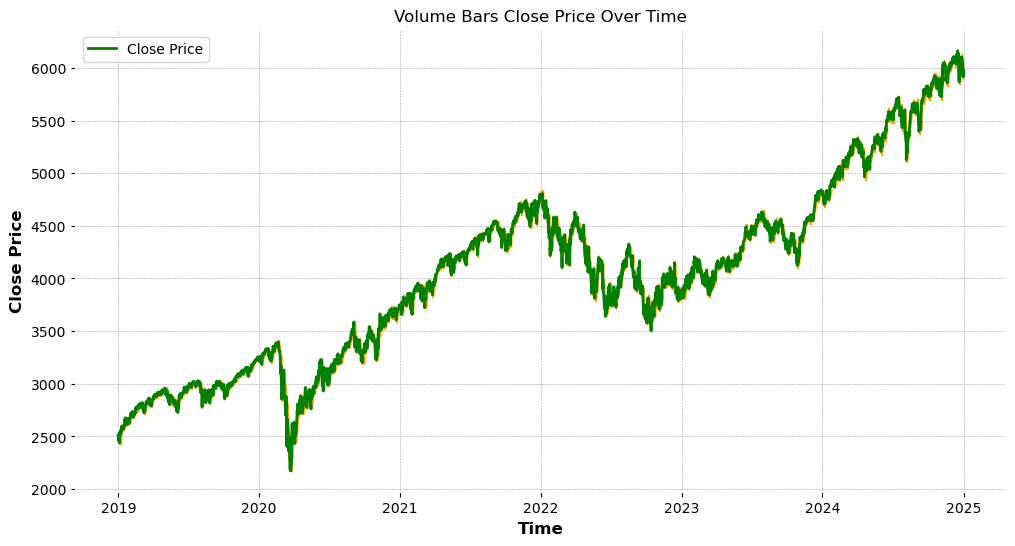

/home/mmx/anaconda3/envs/AFML/lib/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


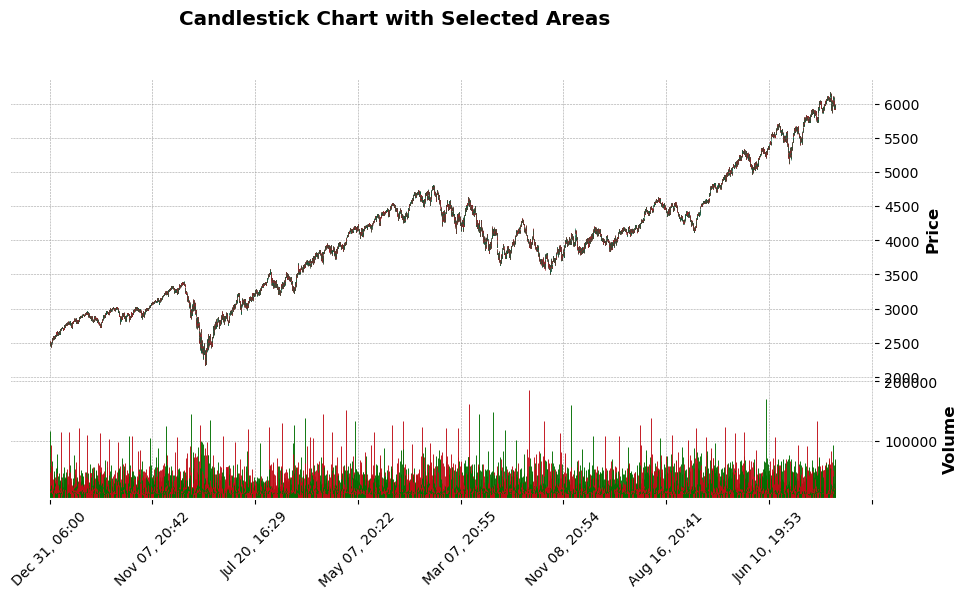

In [17]:
import mplfinance as mpf

plt.figure(figsize=(12, 6))
sns.lineplot(x=volume_bars_df.index, y='Close', data=volume_bars_df, label='Close Price', color='green')

for start, t1, trgt in trigger.itertuples():
    box = Rectangle((start, volume_bars_df.Close.loc[start] - vol.mean() * volume_bars_df.Close.loc[start]), t1 - start,
                    2 * vol.mean() * volume_bars_df.Close.loc[start],
                    linewidth=1, edgecolor='orange', facecolor='none', label='Selected Area')
    plt.gca().add_patch(box)

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Volume Bars Close Price Over Time')
# plt.legend()
plt.grid(True)
plt.show()

# New mplfinance plot
ap_boxes = []
for start, t1, trgt in trigger.itertuples():
    ap_boxes.append(mpf.make_addplot(
        [[volume_bars_df.Close.loc[start],
          volume_bars_df.Close.loc[start] + 2 * vol.mean() * volume_bars_df.Close.loc[start]]],
        linestyle="dashed", color='orange'
    ))

mpf.plot(volume_bars_df, type='candle', style='charles', title='Candlestick Chart with Selected Areas',
          volume=True, figsize=(12, 6))



In [18]:
# 3.1(d) apply getBins to generate labels
bins=my_afml.getBins(trigger,volume_bars_df.Close)
dollar_bins=my_afml.getBins(dollar_trigger,dollar_bars_df.Close)
# bins.head()

In [19]:
# 3.2 drop rare labels
post_drop_bins=dropLabels(bins)
post_drop_bins.head()
post_drop_dollar_bins=dropLabels(dollar_bins)
post_drop_dollar_bins.head()

dropped label 2 0.0030615084887280824
dropped label 2 0.0025302279279092437


,ret,bin
2018-12-31 09:08:00,0.002097,1.0
2018-12-31 12:06:00,-0.001095,-1.0
2018-12-31 13:08:00,0.001297,1.0
2018-12-31 14:34:00,0.000100,1.0
2018-12-31 14:46:00,0.002597,1.0


START OF MODEL FOR META_LABELS

In [20]:
# Start of 3.4
# Define moving average windows
short_window = 5  # e.g., 50 periods
long_window = 20  # e.g., 200 periods

In [21]:
# create events where the moving averages cross over
events = my_afml.movingAverageCrossover(volume_bars_df.Close, short_window, long_window)
# events.head()
# try this with a crossover signa change
events['signal_switch'] = events.signal.diff() / 2
# drop rows with any NaN values
events = events.dropna()
# filter rows where signal_switch is not zero
events = events[events['signal_switch'] != 0]
events.head()

,short_ma,long_ma,signal,signal_switch
Date,,,,
2018-12-31 13:27:00,2506.60,2506.321429,1,1.0
2018-12-31 14:29:00,2505.05,2505.638889,-1,-1.0
2018-12-31 14:39:00,2506.15,2506.000000,1,1.0
2018-12-31 14:46:00,2505.70,2505.716667,-1,-1.0
2018-12-31 17:03:00,2492.50,2491.462500,1,1.0


In [22]:
# create events where the moving averages cross over
dollar_events = my_afml.movingAverageCrossover(dollar_bars_df.Close, short_window, long_window)
# events.head()
# try this with a crossover signa change
dollar_events['signal_switch'] = dollar_events.signal.diff() / 2
# drop rows with any NaN values
dollar_events = dollar_events.dropna()
# filter rows where signal_switch is not zero
dollar_events = dollar_events[dollar_events['signal_switch'] != 0]
dollar_events.head()

,short_ma,long_ma,signal,signal_switch
Date,,,,
2018-12-31 06:56:00,2505.70,2505.500,1,1.0
2018-12-31 08:01:00,2506.85,2506.925,-1,-1.0
2018-12-31 08:32:00,2507.05,2506.975,1,1.0
2018-12-31 08:47:00,2506.60,2506.725,-1,-1.0
2018-12-31 09:47:00,2505.95,2505.775,1,1.0


In [23]:
# and add vertical barrier 1 day from those events (as close to 1 day as possible?)
t1=my_afml.getVb(volume_bars_df.Close,events.index)
dollar_t1=my_afml.getVb(dollar_bars_df.Close,dollar_events.index)

In [24]:
# Now create the meta-labels using the primary model (which provides the side from the crossover point), the t1 vertical barrier which is as close to 1 day as possible from the crossover. We don't label anything as primary model as that was the simple crossover. Meta-labels are used to for secondary model.
# now set ptsl to be lopsided [1,2] which we can do because we now have a 'side' from the moving average crossover. Trigger has column called 'side'
ptsl=[1,2]
# target is set to be standard deviation
trgt=vol.mean()*volume_bars_df.Close
# not sure about min return
minRet=0.00003
numThread=24
# get events will find time of first touch after each event
trigger_secondary_model=my_afml.getEvents(volume_bars_df.Close,events.index,ptsl,trgt,minRet,numThread,t1,events.signal)

Running processJobs


2025-03-04 10:31:07.637398 100.0% applyPtSlOnT1 done after 0.01 minutes. Remaining 0.0 minutes.


In [25]:
#and for dollar bars
ptsl=[1,2]
# target is set to be standard deviation
dollar_trgt=dollar_vol.mean()*dollar_bars_df.Close
# not sure about min return
minRet=0.00003
numThread=24
# get events will find time of first touch after each event
dollar_trigger_secondary_model=my_afml.getEvents(dollar_bars_df.Close,dollar_events.index,ptsl,dollar_trgt,minRet,numThread,t1,dollar_events.signal)

Running processJobs


2025-03-04 10:32:41.507297 100.0% applyPtSlOnT1 done after 1.27 minutes. Remaining 0.0 minutes..


In [26]:
trigger_secondary_model.head()

,t1,trgt,side
Date,,,
2018-12-31 13:27:00,2019-01-01 23:01:00,14.941941,1
2018-12-31 14:29:00,2019-01-01 23:01:00,14.946419,-1
2018-12-31 14:39:00,2019-01-01 23:01:00,14.962837,1
2018-12-31 14:46:00,2019-01-01 23:01:00,14.949404,-1
2018-12-31 17:03:00,2019-01-01 23:01:00,14.901643,1


In [27]:
dollar_trigger_secondary_model.head()

,t1,trgt,side
Date,,,
2018-12-31 06:56:00,NaT,5.297122,1.0
2018-12-31 08:01:00,NaT,5.296065,-1.0
2018-12-31 08:32:00,NaT,5.298178,1.0
2018-12-31 08:47:00,NaT,5.295537,-1.0
2018-12-31 09:47:00,NaT,5.297122,1.0


In [28]:
# getBins will generate the meta-label as we provide a side now in trigger
bins_secondary_model=my_afml.getBins(trigger_secondary_model,volume_bars_df.Close)
dollar_bins_secondary_model=my_afml.getBins(dollar_trigger_secondary_model,dollar_bars_df.Close)

In [29]:
bins_secondary_model.head()
dollar_bins_secondary_model.head()

,ret,bin
Date,,
2019-01-02 13:40:00,0.008931,1.0
2019-01-09 19:01:00,-0.004047,0.0
2019-01-09 19:17:00,0.000193,1.0
2019-01-15 10:43:00,0.007728,1.0
2019-01-22 16:34:00,-0.005668,0.0


In [30]:
# add the crossover data and std to volume_bars for the secondary model
volume_bars_df[['short_ma', 'long_ma', 'signal']] = my_afml.movingAverageCrossover(volume_bars_df.Close, short_window, long_window)
volume_bars_df['std']=my_afml.getDailyVol(volume_bars_df.Close)
# volume_bars_df.head()

In [31]:
dollar_bars_df[['short_ma', 'long_ma', 'signal']] = my_afml.movingAverageCrossover(dollar_bars_df.Close, short_window, long_window)
dollar_bars_df['std']=my_afml.getDailyVol(dollar_bars_df.Close)
# volume_bars_df.head()

/home/mmx/anaconda3/envs/AFML/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mmx/anaconda3/envs/AFML/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mmx/anaconda3/envs/AFML/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mmx/anaconda3/envs/AFML/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

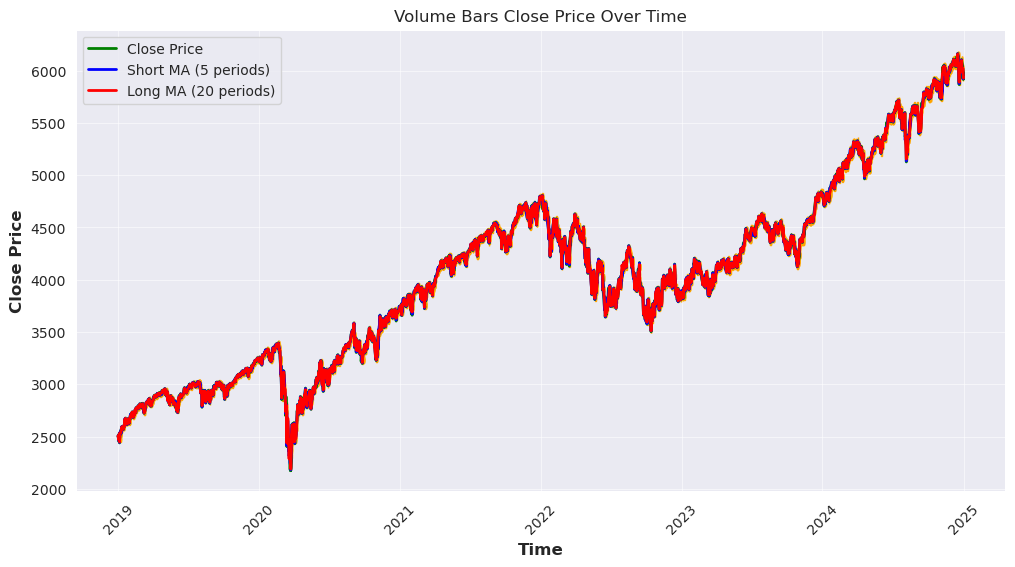

In [32]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=volume_bars_df.index, y='Close', data=volume_bars_df, label='Close Price', color='green')
sns.lineplot(x=volume_bars_df.index, y='short_ma', data=volume_bars_df, label='Short MA (5 periods)', color='blue')
sns.lineplot(x=volume_bars_df.index, y='long_ma', data=volume_bars_df, label='Long MA (20 periods)', color='red')

for start, t1, trgt, _ in trigger_secondary_model.itertuples():
    box = Rectangle((start, volume_bars_df.Close.loc[start] - vol.mean() * volume_bars_df.Close.loc[start]), t1 - start,
                    2 * vol.mean() * volume_bars_df.Close.loc[start],
                    linewidth=1, edgecolor='orange', facecolor='none', label='Selected Area')
    plt.gca().add_patch(box)

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Volume Bars Close Price Over Time')
plt.xticks(rotation=45)
# plt.legend()
plt.grid(True)
plt.show()


In [51]:
# now fit same data using these labels
X=volume_bars_df.loc[bins_secondary_model.index,:]
y=bins_secondary_model['bin']

In [54]:


# Prepare the data
features = X
features.reset_index(drop=True, inplace=True)
features = features.drop(columns=['Symbol'])
labels =y  # Target variable

In [55]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Train RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.6524216524216524
              precision    recall  f1-score   support

         0.0       0.66      0.65      0.66      1776
         1.0       0.65      0.65      0.65      1734

    accuracy                           0.65      3510
   macro avg       0.65      0.65      0.65      3510
weighted avg       0.65      0.65      0.65      3510



In [47]:
# now fit same data using these labels
dollar_X=dollar_bars_df.loc[dollar_bins_secondary_model.index,:]
dollar_y=dollar_bins_secondary_model['bin']

In [49]:

# Prepare the data
features = dollar_X
features.reset_index(drop=True, inplace=True)
features = features.drop(columns=[ 'Symbol'])
labels =dollar_y  # Target variable

In [50]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Train RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.48128342245989303
              precision    recall  f1-score   support

         0.0       0.51      0.54      0.52        99
         1.0       0.45      0.42      0.43        88

    accuracy                           0.48       187
   macro avg       0.48      0.48      0.48       187
weighted avg       0.48      0.48      0.48       187



In [43]:
# try this 4
print(accuracy_score(y_test, y_pred))

0.48128342245989303


In [44]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.51      0.54      0.52        99
         1.0       0.45      0.42      0.43        88

    accuracy                           0.48       187
   macro avg       0.48      0.48      0.48       187
weighted avg       0.48      0.48      0.48       187



In [58]:
highest_dollarvolume_index = dollar_bars_df['DollarVolume'].idxmax()
print(f"Index with the highest DollarVolume: {highest_dollarvolume_index}")

ValueError: No axis named 10 for object type Series

In [64]:
nothing lefttop_10_dollarvolume_indices = dollar_bars_df.nlargest(100, 'DollarVolume').index
print(f"Indices with the top 10 DollarVolumes:\n{top_10_dollarvolume_indices}")
dollar_bars_df.loc[top_10_dollarvolume_indices]

Indices with the top 10 DollarVolumes:
DatetimeIndex(['2024-05-31 20:59:00', '2024-10-31 19:59:00',
               '2022-03-31 20:59:00', '2022-08-31 20:59:00',
               '2022-11-30 20:59:00', '2023-06-30 20:59:00',
               '2024-03-28 19:59:00', '2022-05-31 20:59:00',
               '2024-01-31 20:59:00', '2021-03-31 20:59:00',
               '2022-04-29 20:59:00', '2024-06-28 20:59:00',
               '2024-02-29 20:59:00', '2021-08-31 20:59:00',
               '2021-09-30 20:59:00', '2021-11-30 20:59:00',
               '2021-04-30 20:59:00', '2024-12-20 20:59:00',
               '2022-01-31 20:59:00', '2024-09-30 20:59:00',
               '2021-01-29 20:59:00', '2023-05-31 20:59:00',
               '2022-02-28 20:59:00', '2024-08-30 20:59:00',
               '2023-10-31 19:59:00', '2020-11-30 20:59:00',
               '2023-08-31 20:59:00', '2021-06-30 20:59:00',
               '2024-12-18 20:59:00', '2023-07-31 20:59:00',
               '2023-11-30 20:59:00', '2022-09

,Symbol,Open,High,Low,Close,DollarVolume,bar_number,short_ma,long_ma,signal,std
Date,,,,,,,,,,,
2024-05-31 20:59:00,ESM24,5288.75,5299.50,5286.25,5296.75,8.987366e+08,1250966,5289.40,5271.8125,1,0.005127
2024-10-31 19:59:00,ESZ24,5748.75,5748.75,5734.50,5735.50,7.659703e+08,1351219,5747.55,5757.3250,-1,0.001351
2022-03-31 20:59:00,ESM22,4535.00,4540.75,4526.25,4527.75,7.366287e+08,740430,4534.95,4547.8875,-1,0.002825
2022-08-31 20:59:00,ESU22,3961.00,3962.50,3954.75,3955.75,7.343138e+08,839922,3962.00,3972.0375,-1,0.001752
2022-11-30 20:59:00,ESZ22,4074.75,4083.50,4074.75,4082.50,6.553066e+08,903007,4076.55,4070.8375,1,0.007297
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-12 20:59:00,ESZ24,6012.50,6016.00,6010.50,6012.50,3.505047e+08,1359464,6011.30,6014.4875,-1,0.000985
2023-12-04 20:59:00,ESZ23,4577.50,4578.25,4575.75,4576.75,3.501351e+08,1137113,4577.80,4576.2625,1,0.000794
2024-03-15 19:59:00,ESM24,5177.75,5184.00,5177.75,5182.75,3.497786e+08,1202090,5180.20,5181.1625,-1,0.001954


In [62]:
duplicates = volume_bars_df[volume_bars_df.duplicated()]
print(f"Number of duplicate rows: {len(duplicates)}")
if not duplicates.empty:
    print("Duplicate rows:")
    print(duplicates)

Number of duplicate rows: 0
